# 使用Keras Application模型进行迁移学习
作者：郑灵翔,lxzheng@xmu.edu.cn

使用Keras Application预训练模型，通过迁移学习解决花的分类问题

## 导入相关库

In [1]:
import tensorflow as tf
from tensorflow import keras

## keras 预训练模型
keras.applications预训练模型

In [2]:
IMG_SHAPE=(224, 224, 3)

In [3]:
base_model = keras.applications.EfficientNetB0(input_shape=IMG_SHAPE,
                                                     include_top=False,
                                                     weights='imagenet',
                                                     pooling='avg')

In [4]:
inputs = keras.Input(shape=IMG_SHAPE)
features=base_model(inputs)
outputs=keras.layers.Dense(5,activation='softmax')(features)
model = keras.Model(inputs=inputs, outputs=outputs)

In [5]:
base_model.trainable=False

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 4,055,976
Trainable params: 6,405
Non-trainable params: 4,049,571
_________________________________________________________________


## 数据预处理

In [7]:
dataset_url='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
dataset_file = tf.keras.utils.get_file(origin=dataset_url,extract=True)

In [8]:
import os
fname=os.path.basename(dataset_file)
dataset_path=os.path.dirname(dataset_file)+'/'+fname.split('.')[0]

In [9]:
%ls $dataset_path

LICENSE.txt  daisy/  dandelion/  roses/  sunflowers/  tulips/


In [10]:
image_generator = keras.preprocessing.image.ImageDataGenerator(validation_split=0.10)

training_generator = image_generator.flow_from_directory(dataset_path, 
                                                         target_size=(224,224),
                                                         subset='training',
                                                         batch_size=4)
val_generator = image_generator.flow_from_directory(dataset_path, 
                                                    target_size=(224,224),
                                                    subset='validation',
                                                    batch_size=4)

Found 3306 images belonging to 5 classes.
Found 364 images belonging to 5 classes.


In [11]:
class_names=list(training_generator.class_indices.keys())
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## 模型训练

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


In [13]:
his=model.fit(training_generator,epochs=30,validation_data=val_generator)

Epoch 1/30
827/827 [==============================] - 22s 19ms/step - loss: 1.5048 - accuracy: 0.3769 - val_loss: 1.3765 - val_accuracy: 0.4588
Epoch 2/30
827/827 [==============================] - 14s 17ms/step - loss: 1.2798 - accuracy: 0.5541 - val_loss: 1.2003 - val_accuracy: 0.5934
Epoch 3/30
827/827 [==============================] - 13s 16ms/step - loss: 1.1216 - accuracy: 0.6485 - val_loss: 1.0706 - val_accuracy: 0.6786
Epoch 4/30
827/827 [==============================] - 13s 16ms/step - loss: 0.9983 - accuracy: 0.7081 - val_loss: 0.9710 - val_accuracy: 0.7225
Epoch 5/30
827/827 [==============================] - 14s 17ms/step - loss: 0.9006 - accuracy: 0.7417 - val_loss: 0.8929 - val_accuracy: 0.7390
Epoch 6/30
827/827 [==============================] - 13s 16ms/step - loss: 0.8241 - accuracy: 0.7632 - val_loss: 0.8302 - val_accuracy: 0.7500
Epoch 7/30
827/827 [==============================] - 13s 16ms/step - loss: 0.7632 - accuracy: 0.7864 - val_loss: 0.7783 - val_accuracy:

In [14]:
import numpy as np
import matplotlib.pyplot as plt

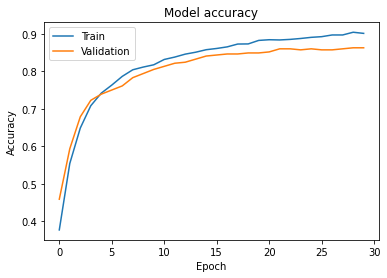

In [15]:
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

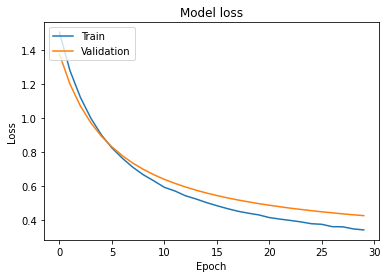

In [16]:
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## 解冻模型高层，进行微调训练

In [17]:
len(base_model.layers)

238

In [18]:
base_model.trainable=True

In [19]:
for layer in base_model.layers[:-17]:
    layer.trainable = False
for layer in base_model.layers[-17:]:
    print(layer.name)
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

block7a_expand_conv
block7a_expand_bn
block7a_expand_activation
block7a_dwconv
block7a_bn
block7a_activation
block7a_se_squeeze
block7a_se_reshape
block7a_se_reduce
block7a_se_expand
block7a_se_excite
block7a_project_conv
block7a_project_bn
top_conv
top_bn
top_activation
avg_pool


In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 4,055,976
Trainable params: 1,127,989
Non-trainable params: 2,927,987
_________________________________________________________________


In [21]:
his1=model.fit(training_generator,epochs=20,validation_data=val_generator)

Epoch 1/20
827/827 [==============================] - 14s 17ms/step - loss: 0.3366 - accuracy: 0.9047 - val_loss: 0.4204 - val_accuracy: 0.8626
Epoch 2/20
827/827 [==============================] - 14s 17ms/step - loss: 0.3324 - accuracy: 0.9023 - val_loss: 0.4160 - val_accuracy: 0.8709
Epoch 3/20
827/827 [==============================] - 14s 17ms/step - loss: 0.3269 - accuracy: 0.9047 - val_loss: 0.4117 - val_accuracy: 0.8654
Epoch 4/20
827/827 [==============================] - 14s 17ms/step - loss: 0.3227 - accuracy: 0.9032 - val_loss: 0.4078 - val_accuracy: 0.8626
Epoch 5/20
827/827 [==============================] - 14s 17ms/step - loss: 0.3192 - accuracy: 0.9041 - val_loss: 0.4040 - val_accuracy: 0.8626
Epoch 6/20
827/827 [==============================] - 13s 16ms/step - loss: 0.3162 - accuracy: 0.9056 - val_loss: 0.4003 - val_accuracy: 0.8626
Epoch 7/20
827/827 [==============================] - 13s 16ms/step - loss: 0.3079 - accuracy: 0.9102 - val_loss: 0.3969 - val_accuracy:

In [24]:
import numpy as np
import matplotlib.pyplot as plt

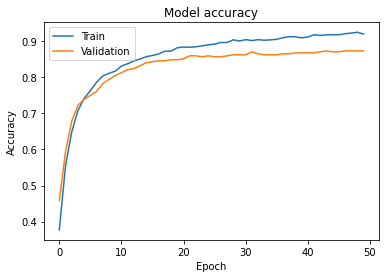

In [25]:
acc_his=his.history['accuracy']
for acc in his1.history['accuracy']:
    acc_his.append(acc)
    
val_acc_his=his.history['val_accuracy']
for acc in his1.history['val_accuracy']:
    val_acc_his.append(acc)
    
plt.plot(acc_his)
plt.plot(val_acc_his)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

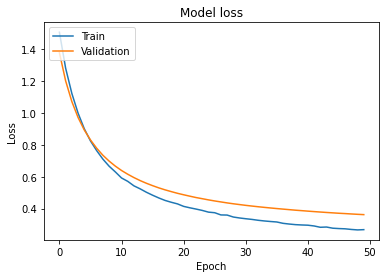

In [60]:
los_his=his.history['loss']
for los in his1.history['loss']:
    los_his.append(los)
    
val_los_his=his.history['val_loss']
for los in his1.history['val_loss']:
    val_los_his.append(los)
    
plt.plot(los_his)
plt.plot(val_los_his)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="知识共享许可协议" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />本作品采用<a rel="license" href="http://creativecommons.org/licenses/by/4.0/">知识共享署名 4.0 国际许可协议</a>进行许可。